[Reference](https://towardsdatascience.com/time-series-smoothing-for-better-forecasting-7fbf10428b2)

In [2]:
pip install tsmoothie

In [6]:
pip install keras-hypetune

In [7]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tsmoothie.smoother import *
from tsmoothie.utils_func import create_windows

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

from kerashypetune import KerasGridSearch

In [8]:
### READ AND MANAGE DATA ###

df = pd.read_csv('https://raw.githubusercontent.com/cerlymarco/MEDIUM_NoteBook/master/TimeSeries_Smoothing_Forecasting/PV_Elec_Gas2.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df['Power'] = df.cum_power.diff()
df.drop(['cum_power'], axis=1, inplace=True)
df.dropna(inplace=True)
print(df.shape)

df.head()

(2947, 3)


,Elec_kW,Gas_mxm,Power
2011-10-27,7.4,9.2,10.1
2011-10-28,5.8,8.0,10.0
2011-10-29,4.9,6.6,9.4
2011-10-30,11.7,5.3,4.6
2011-10-31,11.0,5.7,3.8


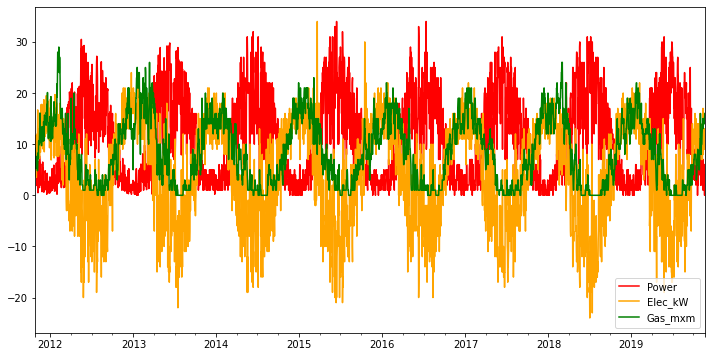

In [9]:
### PLOT RAW DATA ###

plt.figure(figsize=(12,6))

df.Power.plot(c='red')
df.Elec_kW.plot(c='orange')
df.Gas_mxm.plot(c='green')
plt.legend()

In [10]:
### USE KALMAN FILTER TO SMOOTH ALL DATA (ONLY VISUALIZATION PURPOSE) ###

smoother = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=365)
smoother.smooth(df[['Elec_kW','Gas_mxm','Power']].T)

<tsmoothie.smoother.KalmanSmoother>

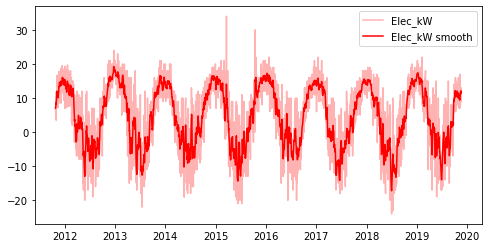

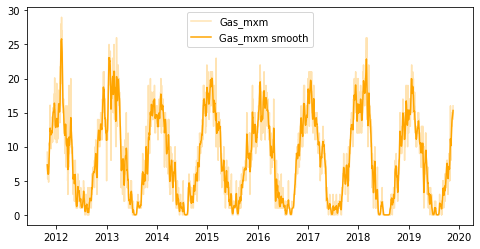

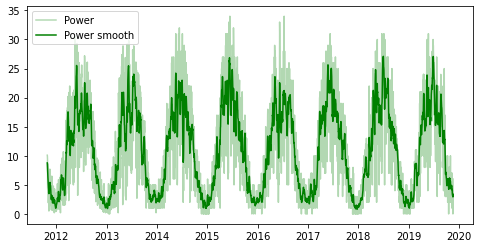

In [11]:
### PLOT RAW vs SMOOTHED DATA ###

color = {0:'red', 1:'orange', 2:'green'}

for i,name in enumerate(df.columns):
    
    plt.figure(figsize=(8,4))
    plt.plot(df.index, smoother.data[i], c=color[i], label=name, alpha=0.3)
    plt.plot(df.index, smoother.smooth_data[i], c=color[i], label=name+' smooth')
    plt.legend(); plt.show()

In [12]:
### TRAIN TEST SPLIT ###

X_train_val, X_test, y_train_val, y_test = train_test_split(df[['Elec_kW','Gas_mxm','Power']].values, df[['Power']].values, 
                                                            test_size=0.2, shuffle=False)

y_train_val.shape, y_test.shape

((2357, 1), (590, 1))

In [13]:
### USE KALMAN FILTER TO SMOOTH ONLY THE TARGET ON TRAIN/VAL DATA ###

smoother = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=365)
smoother.smooth(y_train_val.T)

<tsmoothie.smoother.KalmanSmoother>

In [14]:
### SLICE TRAIN/VAL DATA INTO EQUAL SLIDING WINDOWS ###

window_shape = 20
target_seq = 5

X_train_val = create_windows(X_train_val, window_shape=window_shape, 
                             end_id=-target_seq)
X_train_val.shape

(2333, 20, 3)

In [16]:
### SLICE TEST DATA INTO EQUAL SLIDING WINDOWS ###

X_test = create_windows(X_test, window_shape=window_shape, 
                        end_id=-target_seq)
X_test.shape

(566, 20, 3)

In [17]:
### CREATE SLIDING WINDOWS RAW TRAIN/VAL TARGET ###

y_train_val = create_windows(smoother.data.T, window_shape=target_seq, 
                             start_id=window_shape)
y_train_val.shape

(2333, 5, 1)

In [18]:
### CREATE SLIDING WINDOWS SMOOTH TRAIN/VAL TARGET ###

y_smooth_train_val = create_windows(smoother.smooth_data.T, window_shape=target_seq, 
                                    start_id=window_shape)
y_smooth_train_val.shape

(2333, 5, 1)

In [19]:
### SLICE TEST TARGET INTO EQUAL SLIDING WINDOWS ###

y_test = create_windows(y_test, window_shape=target_seq, 
                        start_id=window_shape)
y_test.shape

(566, 5, 1)

In [20]:
### TRAIN VAL SPLIT ###

X_train, X_val, y_train_raw, y_val_raw = train_test_split(X_train_val, y_train_val, test_size=0.1, shuffle=False)
X_train, X_val, y_train_smooth, y_val_smooth = train_test_split(X_train_val, y_smooth_train_val, test_size=0.1, shuffle=False)

In [21]:
### SCALE INPUT ###

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [22]:
### SCALE SMOOTH TARGET ###

scaler_target_smooth = StandardScaler()
y_train_smooth = scaler_target_smooth.fit_transform(y_train_smooth.reshape(-1, y_train_smooth.shape[-1])).reshape(y_train_smooth.shape)
y_val_smooth = scaler_target_smooth.transform(y_val_smooth.reshape(-1, y_val_smooth.shape[-1])).reshape(y_val_smooth.shape)

In [23]:
### SCALE RAW TARGET ###

scaler_target = StandardScaler()
y_train_raw = scaler_target.fit_transform(y_train_raw.reshape(-1, y_train_raw.shape[-1])).reshape(y_train_raw.shape)
y_val_raw = scaler_target.transform(y_val_raw.reshape(-1, y_val_raw.shape[-1])).reshape(y_val_raw.shape)

In [24]:
### UTILITY FUNCTIONS FOR HYPERPARAM SEARCH ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param):
    
    set_seed(33)

    model = Sequential()
    model.add(LSTM(param['unit'], activation=param['act']))
    model.add(RepeatVector(target_seq))
    model.add(LSTM(param['unit'], activation=param['act'], return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    opt_choices = {'adam': Adam(),
                   'rms': RMSprop()}
    
    opt = opt_choices[param['opt']]
    opt.lr = param['lr'] 
    
    model.compile(opt, 'mse')
    
    return model

In [25]:
### CREATE GRID FOR HYPERPARAM SEARCH ###

param_grid = {
    'unit': [128,64,32], 
    'lr': [1e-2,1e-3], 
    'act': ['elu','relu'], 
    'opt': ['adam','rms'],
    'epochs': 200,
    'batch_size': 512
}

In [26]:
### FIT + HYPERPARAM SEARCH WITH RAW TARGET ###

es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = get_model

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train_raw, validation_data=(X_val, y_val_raw), callbacks=[es])


24 trials detected for ('unit', 'lr', 'act', 'opt', 'epochs', 'batch_size')

***** (1/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'relu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 0.18114 at epoch 39

***** (2/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'relu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.17725 at epoch 33

***** (3/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'elu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 0.18742 at epoch 24

***** (4/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'elu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.17429 at epoch 22

***** (5/24) *****
Search({'unit': 128, 'lr': 0.001, 'act': 'relu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 0.17615 at epoch 33

***** (6/24) *****
Search({'unit': 128, 'lr': 0.001, 'act': 'relu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.17448 at epoch 29

***** (7/24) *****
Search({'unit': 128, 'lr': 0.001, 'a

<kerashypetune.KerasGridSearch>

In [27]:
### GET BEST STATISTICS ###

kgs.best_score, kgs.best_params

(0.16538,
 {'act': 'relu',
  'batch_size': 512,
  'epochs': 37,
  'lr': 0.01,
  'opt': 'adam',
  'steps_per_epoch': 5,
  'unit': 32})

In [28]:
### REVERSE PREDICTIONS ###

pred_raw = kgs.best_model.predict(X_test)
pred_raw = scaler_target.inverse_transform(pred_raw.reshape(-1, pred_raw.shape[-1])).reshape(pred_raw.shape)

In [29]:
### CALCULATE MSE FOR EACH PREDICTION HORIZONS ###

mse_raw = {}

for i in range(target_seq):
    
    mse = mean_squared_error(y_test[:,i,0], pred_raw[:,i,0])
    mse_raw['day + {i}'.format(i=i+1)] = mse
    
    print('pred day + {i}: {mse} MSE'.format(i=i+1, mse=mse))

pred day + 1: 27.121660434239956 MSE
pred day + 2: 27.487026433008424 MSE
pred day + 3: 28.461792766946513 MSE
pred day + 4: 29.776055172730263 MSE
pred day + 5: 30.401690384667358 MSE


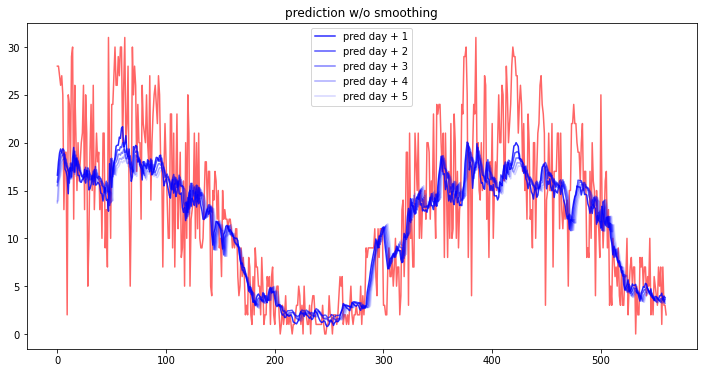

In [30]:
### PLOT EACH PREDICTION HORIZONS ON THE SAME PLOT ###

plt.figure(figsize=(12,6))

plt.plot(y_test[target_seq:,0,0], c='red', alpha=0.6)

for i in range(target_seq):
        
    plt.plot(pred_raw[(target_seq-i):-(i+1),i,0], 
             c='blue', alpha=1-1/(target_seq+1)*(i+1),
             label='pred day + {i}'.format(i=i+1))
    
plt.title('prediction w/o smoothing'); plt.legend()

In [31]:
### FIT + HYPERPARAM SEARCH WITH SMOOTH TARGET ###

es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = get_model

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train_smooth, validation_data=(X_val, y_val_smooth), callbacks=[es])


24 trials detected for ('unit', 'lr', 'act', 'opt', 'epochs', 'batch_size')

***** (1/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'relu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 0.08454 at epoch 22

***** (2/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'relu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.0618 at epoch 40

***** (3/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'elu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 0.06998 at epoch 22

***** (4/24) *****
Search({'unit': 128, 'lr': 0.01, 'act': 'elu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.05895 at epoch 41

***** (5/24) *****
Search({'unit': 128, 'lr': 0.001, 'act': 'relu', 'opt': 'rms', 'epochs': 200, 'batch_size': 512})
SCORE: 0.06766 at epoch 39

***** (6/24) *****
Search({'unit': 128, 'lr': 0.001, 'act': 'relu', 'opt': 'adam', 'epochs': 200, 'batch_size': 512})
SCORE: 0.0626 at epoch 32

***** (7/24) *****
Search({'unit': 128, 'lr': 0.001, 'act

<kerashypetune.KerasGridSearch>

In [ ]:
### GET BEST STATISTICS ###

kgs.best_score, kgs.best_params

In [ ]:
### REVERSE PREDICTIONS ###

pred_smooth = kgs.best_model.predict(X_test)
pred_smooth = scaler_target_smooth.inverse_transform(pred_smooth.reshape(-1, pred_smooth.shape[-1])).reshape(pred_smooth.shape)

In [ ]:
### CALCULATE MSE FOR EACH PREDICTION HORIZONS ###

mse_smooth = {}

for i in range(target_seq):
    
    mse = mean_squared_error(y_test[:,i,0], pred_smooth[:,i,0])
    mse_smooth['day + {i}'.format(i=i+1)] = mse 
    
    print('pred day + {i}: {mse} MSE'.format(i=i+1, mse=mse))

In [ ]:
### PLOT EACH PREDICTION HORIZON ON THE SAME PLOT ###

plt.figure(figsize=(12,6))

plt.plot(y_test[target_seq:,0,0], c='red', alpha=0.6)

for i in range(target_seq):
        
    plt.plot(pred_smooth[(target_seq-i):-(i+1),i,0], 
             c='blue', alpha=1-1/(target_seq+1)*(i+1),
             label='pred day + {i}'.format(i=i+1))
    
plt.title('prediction w/ smoothing'); plt.legend()

In [ ]:
### CALCULATE BASELINE MSE FOR EACH PREDICTION HORIZONS ###

mse_baseline = {}

for i in range(target_seq):
    
    mse = mean_squared_error(y_test[1:,i,0], y_test[:-1,0,0])
    mse_baseline['day + {i}'.format(i=i+1)] = mse 
    
    print('pred day + {i}: {mse} MSE'.format(i=i+1, mse=mse))

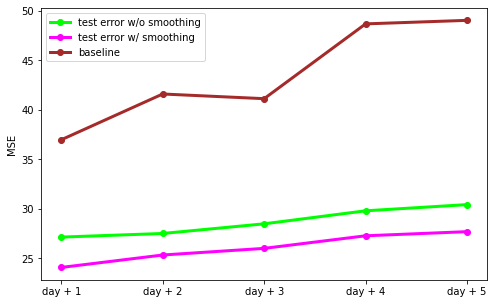

In [37]:
### PLOT MSE FOR EACH PREDICTION HORIZONS ###

plt.figure(figsize=(8,5))

plt.plot(list(mse_raw.values()), label='test error w/o smoothing', 
         c='lime', linewidth=3, marker='o')
plt.plot(list(mse_smooth.values()), label='test error w/ smoothing', 
         c='magenta', linewidth=3, marker='o')
plt.plot(list(mse_baseline.values()), label='baseline', 
         c='brown', linewidth=3, marker='o')

plt.xticks(range(target_seq), mse_smooth.keys())
plt.ylabel('MSE'); plt.legend()
np.set_printoptions(False)